In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import gensim, logging
from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [2]:
def preprocess(text,pos=True,n_tags=None,filt=True,lower=False,BOW=False):
    """
    Input text string, return tokenized, postagged, filted tokens.
    """
    if filt:
        negative_tags = ['$',"''",'(',')','--','.',',',':','DT','CC','IN','TO']
        if n_tags:
            negative_tags.extend(n_tags)
    else:
        negative_tags = []
    
    if lower:
        text = text.lower()
        
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    filted_tokens = [(tok,pos) for (tok,pos) in tagged_tokens if pos not in negative_tags]
    
    if pos:
        if BOW:
            return list(set(filted_tokens))
        else:
            return filted_tokens
    else:
        if BOW:
            return list(set(tokens))
        else:
            return tokens
    
def mapidx(dataframe,colname):
    
    c = Counter()
    
    for idx,row in dataframe.iterrows():
        label = str(row[colname]).split(',')
        c.update(label)
        
    keys = sorted(c.keys())
    mapidx = {key:idx for idx,key in enumerate(keys)}
    
    return mapidx

def data2feats(df_,vector_model,col=['CATS','WELLGOS'],we_size=200):
    
    concatfeats = False
    
    if 'TOPICS' in col:
        col = [c for c in col if c != 'TOPICS']
        w2vfeats = np.zeros([df_.shape[0],we_size*len(df.ix[0]['TOPICS'].split(','))])
        #print(w2vfeats.shape)
        for idx,row in df_.iterrows():
            vec = []
            for t in row['TOPICS'].split(','):
                try:
                    vec.append(vector_model[t])
                except KeyError:
                    print('KeyError: ', t, idx)
                    pass
            #embeddings = np.array([vector_model[t] for t in row['TOPICS'].split(',')])
            embeddings = np.array(vec)
            try:
                w2vfeats[idx,:] = embeddings.ravel()
            except ValueError:
                print('ValueError ', idx)
                pass
        concatfeats = True
    
    d_idx = {colname:mapidx(df_,colname) for colname in col}
    
    feats_col_n = sum([len(v) for k,v in d_idx.items()])
    
    feats = np.zeros([df_.shape[0],feats_col_n])
    #print(feats.shape)
    
    # Extend idx to fit feature col size
    for idx,colname in enumerate(col):
        if idx == 1:
            for k,v in d_idx[colname].items():
                d_idx[colname][k] += len(d_idx[col[idx-1]])
        if idx > 1:
            for k,v in d_idx[colname].items():
                d_idx[colname][k] += sum([len(d_idx[col[idx-(i+1)]]) for i in range(idx)])
    
    for idx,row in df_.iterrows():
        for i,colname in enumerate(col):
            elements = str(row[colname]).split(',')
            element_idxs = [d_idx[colname][e] for e in elements]
            for e_idx in element_idxs:
                feats[idx,e_idx] = 1
     
    if concatfeats:
        new_feats = np.concatenate((feats,w2vfeats),axis=1)
        #print(new_feats.shape)
        return d_idx,new_feats
    else:
        return d_idx,feats
    
    
def getlabels(df_,colname):
    
    c = Counter()
    for idx,row in df_.iterrows():
        c.update(row[colname].split(','))
        
    keys = sorted(c.keys())
    d_idx = {k:i for i,k in enumerate(keys)}
    
    labels = np.zeros([df_.shape[0]],dtype=int)
    
    for idx,row in df_.iterrows():
        labels[idx] = d_idx[row[colname]]
        
    return d_idx,labels
    

def plotclusters(feats_2d,km_labels,df_,legloc='lower left'):
    
    l_focus = df_['FOCUS'].values
    l_names = df_['N']
    l_gender = df_['GENDER']
    
    fig,axes =plt.subplots(2,2, sharey=True,figsize=(16,16))
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    ax4 = axes[1,1]
    
    # KMeans Plot
    #ax1.set_title('K Means')
    #ax1.scatter(feats_2d[:,0],feats_2d[:,1],c=km_labels,s=50,linewidth=0.1,cmap='rainbow')
    
    # Other
    def plotrest(ax,name,lst):
        ax.set_title(name)
        label_added = []
        cmap = {l:c for l,c in zip(sorted(set(lst)),cm.rainbow(np.linspace(0,0.9,len(set(lst)))))}
        colors = [cmap[l] for l in lst]
        for i,c in enumerate(colors):
            x = feats_2d[i,0]
            y = feats_2d[i,1]
            l = lst[i]
            if l not in label_added:
                ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)
                label_added.append(l)
            else:
                ax.scatter(x, y, s=50, linewidth=0.1, c=c)
        ax.legend(loc=legloc)
        
    plotrest(ax1,'KMeans',km_labels)    
    plotrest(ax2,'FOCUS',l_focus)
    plotrest(ax3,'NAME',l_names)
    plotrest(ax4,'GENDER',l_gender)
    

def getlabel(df_,km_labels,clusters):
    
    examples = []
    
    for c in clusters:
        l = [idx for idx,label in enumerate(km_labels) if label == c]
        examples.append(l)
        print('Cluster %i: %i examples' %(c, len(l))) 
        print('%s\n%s\n%s\n' %(Counter(df_.ix[l]['GENDER']), Counter(df_.ix[l]['FOCUS']), Counter(df_.ix[l]['N'])))                                         
    if len(clusters) == 1:
        return examples[0]
    else:
        return examples

def count(df_,colname,l,cname,topN=10,pos=False):
    
    c = Counter()
    for line in df_.ix[l][colname]:
        c.update(line.split(','))
    
    if not pos:
        print('Total unique %s in Cluster %i: %i\n' %(colname, cname, len(c.keys())))

        print('Most Common: ')

        for x in c.most_common(topN):
            print(x)
        print('\n')
    else: 
        tagged = nltk.pos_tag(c.keys()) #[w for w in c.keys() if w != '']
        
        dpos = {w:t for w,t in tagged}
        
        print('Total unique %s in Cluster %i: %i\n' %(colname, cname, len(c.keys())))
        
        print('Most Common Verbs: ')
        for x in c.most_common(topN):
            #if x[0] != '':
            if dpos[x[0]][:2] == 'VB':
                print(x)
        print('\nMost Common non-Verbs: ')
        for x in c.most_common(topN):
            #if x[0] != '':
            if dpos[x[0]][:2] != 'VB':
                print(x)
        print('\n')

def overlap2d(df_,catname,welgname):
    
    c_cats = Counter()
    c_welg = Counter()

    for x in df_[catname]:
        c_cats.update(x.split(','))

    for x in df_[welgname]:
        c_welg.update(x.split(','))

    cats = sorted(c_cats.keys())
    welgs = sorted(c_welg.keys())

    c_matrix = np.zeros([len(cats),len(welgs)],dtype=int)

    for idx,row in df_.iterrows():
        cat = row[catname].split(',')
        welg = row[welgname].split(',')
        for c in cat:
            for w in welg:
                c_matrix[cats.index(c),welgs.index(w)] += 1
    
    return cats,welgs,c_matrix

def matrix2df_(cols,rows,matrix):
    _df = pd.DataFrame(index=cols,columns=rows,data=matrix)
    return _df

def topNoverlap_(df_,n=10):
    
    rows = df_.index
    cols = df_.columns
    tops = []
    
    for idx,row in df_.iterrows():
        sortedlst = sorted([(count,idx) for idx,count in enumerate(row)],reverse=True)
        topN = [(cols[idx],count) for count,idx in sortedlst[:n]]
        tops.append(topN)
        
    new_df = pd.DataFrame(index=rows,columns=range(1,n+1),data=tops)
    return new_df

def normalize(doc,onlylemma=False):
    """doc is string, i.e. Sugar is bad to consume. My sister likes to have sugar, but not my father."""
    
    stop = set(stopwords.words('english')) #high freq non indicative words
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    
    tokens = nltk.word_tokenize(doc.lower())
    normalized = [lemma.lemmatize(token) for token in tokens]
    punc_free = [w for w in normalized if w not in exclude]
    stop_free = [w for w in punc_free if w not in stop]
    
    if onlylemma:
        return punc_free
    else:
        return stop_free

def ldatopicmodeling(raw,n_topics=1,n_w=10):
    
    raw_clean = [normalize(raw)]
    dic = corpora.Dictionary(raw_clean)
    doc_term_matrix = [dic.doc2bow(w) for w in raw_clean]
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=n_topics, id2word = dic, passes=20)
    
    return ldamodel.top_topics(doc_term_matrix,num_words=n_w)
    
    

In [3]:
df = pd.read_csv('GenderEven207.csv')
df['TOKENS'] = None
df['TOPICS'] = None
df['nVecTOPICS'] = None

for idx,row in df.iterrows():
    #pp = preprocess(row['RAW'],pos=True,n_tags=['PRP','PRP$','RB','MD','WRB','NNP'],BOW=True)
    row['TOKENS'] = ','.join(normalize(row['RAW'],onlylemma=False))
    row['TOPICS'] = row['nVecTOPICS'] = ','.join([t for s,t in ldatopicmodeling(row['RAW'],n_topics=1,n_w=5)[0][0]]) 
    

try:
    bool(word2vec)
except NameError:
    df_w2v = pd.read_csv('data_-c_removed.csv')
    df_w2v['TOKENS'] = None

    for idx,row in df_w2v.iterrows():
        pp = normalize(row['RAW'],onlylemma=True)
        #pp = preprocess(row['RAW'],pos=False,lower=True)
        row['TOKENS'] = pp

    scentence = df_w2v['TOKENS']
    word2vec = gensim.models.word2vec.Word2Vec(scentence, min_count=1, size=200, workers=2)
    del(df_w2v)
    
#try:
    #bool(word2vec_goo)
#except NameError:
    #word2vec_goo = gensim.models.word2vec.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [11]:
df

,RAW,CATS,WELLGOS,FOCUS,N,GENDER,TOKENS,TOPICS,nVecTOPICS
0,"Throughout my drinking career, instant gratifi...","PROGRESS / start small,INNER MASTERY / take a ...","Baby Step Embracer,Finish Line Forgetter,The M...",DRUGS/ALC,Paul,male,"throughout,drinking,career,instant,gratificati...","wanted,master,baby,step,time","wanted,master,baby,step,time"
1,I tried to control every aspect of my life. Wh...,"CONTROL,SERENITY,FREEDOM / past & let go,TRUST...","Controller Coaster,Should Shover,Serenity Simu...",DRUGS/ALC,Paul,male,"tried,control,every,aspect,life,thing,didn’t,g...","thing,go,control,life,way","thing,go,control,life,way"
2,Thinking about drinking – the taste and feel –...,"CRAVINGS / will power & tools,INNER POWER / Se...","Pattern Interrupter,New Pattern Painter,Craver...",DRUGS/ALC,Paul,male,"thinking,drinking,–,taste,feel,–,made,salivate...","like,–,ha,pure,thinking","like,–,ha,pure,thinking"
3,I always thought today/this weekend/this week ...,"DELUSION,CONFESSION / denial,TRUTH / self honesty","Delusion Detector,Sabotage SOS’r,Insanity SOS’...",DRUGS/ALC,Paul,male,"always,thought,today/this,weekend/this,week,wa...","would,drinking,stop,time,like","would,drinking,stop,time,like"
4,The people around me only saw what I wanted th...,"CONFIDENCE / acceptance & worth,DELUSION,VULNE...","Self Esteem Elixir,Confidence Caffeinator,Inne...",DRUGS/ALC,Paul,male,"people,around,saw,wanted,see,thought,mask,stro...","friend,see,wa,seeing,liked","friend,see,wa,seeing,liked"
5,Resigned to the fact that being poor or homele...,"CONFIDENCE / hope & future,FREEDOM / past & l...","Excuse Exterminator,Rationalization Rinser,Gra...",DRUGS/ALC,Paul,male,"resigned,fact,poor,homeless,wa,fate,store,drin...","poor,better,homeless,fate,drinking","poor,better,homeless,fate,drinking"
6,"Alcohol was great for two things, suppressing ...","WORTHINESS / connections & sharing,VULNERABILI...","Emotions Engineer,Feelings Fantasizer,Compassi...",DRUGS/ALC,Paul,male,"alcohol,wa,great,two,thing,suppressing,emotion...","feeling,else’s,suppressing,didn’t,i’m","feeling,else’s,suppressing,didn’t,i’m"
7,I’ve started more things than I can count and ...,"COMMITMENTS,MOTIVATION,RESPONSIBILITY,INNER PO...","Finish Line Forgetter,The Procrastina-shunner,...",DRUGS/ALC,Paul,male,"i’ve,started,thing,count,finished,say,wa,whims...","thing,finish,say,truly,need","thing,finish,say,truly,need"
8,How great it was to have a friend that I could...,"EGO,PRIDE ,INFLUENCES,COMMUNITY / healthy rela...","Foul Weather Friender,Arrogance Arrestor,Pride...",DRUGS/ALC,Paul,male,"great,wa,friend,could,get,whine,complain,perso...","friend,like,wa,person,drinking","friend,like,wa,person,drinking"
9,Diving headlong into whatever had caught my in...,"COMMITMENTS,PROGRESS / start small,INNER POWER...","Symbolic Stepper,New Pattern Painter / grit & ...",DRUGS/ALC,Paul,male,"diving,headlong,whatever,caught,interest,think...","basic,done,start,job,i’ve","basic,done,start,job,i’ve"


In [13]:
df.ix[0]['TOKENS']

'taking,do,being,day,trades,comes,mind,action,up,walk,master,okay,what,master,down,remember,baby,better,be,career,wake,decide,didn’t,learned,everything,have,slowing,gratification,couple,give,none,took,learned,time,one,want,reasons,steps,course,set,–,work,goals,wanted,deliberate,was,instant,doing,walk,jack,drinking,towards,is,slow,norm'

In [14]:
df.ix[0]['RAW']

'Throughout my drinking career, instant gratification was the norm. I wanted what I wanted, and I wanted it all, right now! I have learned that almost everything I do comes in baby steps. I have to remember that when I first learned how to walk, I didn’t just wake up one day and walk perfectly, it took time. Now, as I work towards goals, taking baby steps is okay with me, for a couple of reasons. Firstly, baby steps slow me down and give me time to decide if my course of action is really what I want. Secondly, by slowing down and being deliberate, I can better master what I’m doing – instead of being a jack of all trades, master of none, I can be a master of what I set my mind to doing.'

In [22]:
','.join(normalize(df.ix[0]['RAW'],onlylemma=True))

'throughout,my,drinking,career,instant,gratification,wa,the,norm,i,wanted,what,i,wanted,and,i,wanted,it,all,right,now,i,have,learned,that,almost,everything,i,do,come,in,baby,step,i,have,to,remember,that,when,i,first,learned,how,to,walk,i,didn’t,just,wake,up,one,day,and,walk,perfectly,it,took,time,now,a,i,work,towards,goal,taking,baby,step,is,okay,with,me,for,a,couple,of,reason,firstly,baby,step,slow,me,down,and,give,me,time,to,decide,if,my,course,of,action,is,really,what,i,want,secondly,by,slowing,down,and,being,deliberate,i,can,better,master,what,i’m,doing,–,instead,of,being,a,jack,of,all,trade,master,of,none,i,can,be,a,master,of,what,i,set,my,mind,to,doing'

# ONLY TOKENS

Feats Shape:  (414, 4354)
Included:  dict_keys(['TOKENS'])


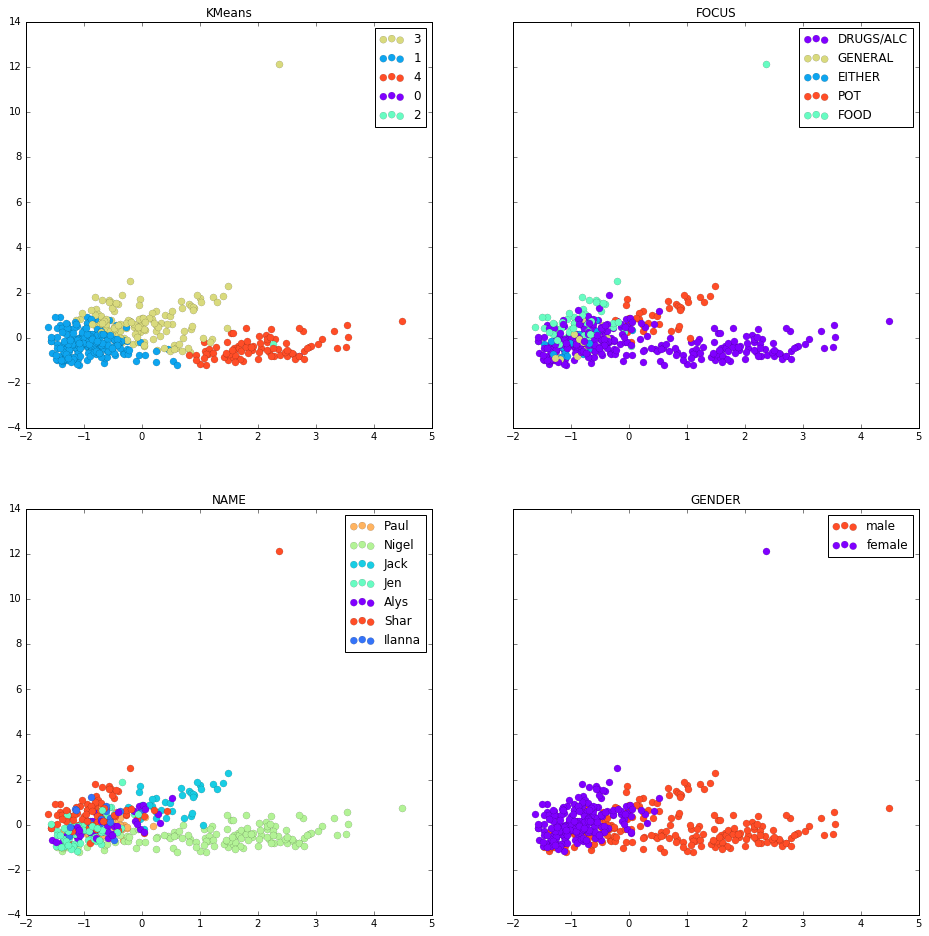

In [12]:
d_idx,feats = data2feats(df,word2vec,col=['TOKENS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=5,max_iter=500)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Tokens are elements such as word and punctuation, here non-indicative tokens such have been filtered. So throwing only tokens into the cluster algorithm, if two people use similar words to describe their recovery path, they should be grouped into the same cluster.

As shown in KMeans figure and below stats, in terms of language, examples with name 'Nigel' are very similar. Cluster 1 and 3 share some similarity as well.

In [15]:
l1,l3,l4 = getlabel(df,kmeans.labels_,clusters=[1,3,4])
count(df,'TOKENS',l1,1,topN=15,pos=False)
count(df,'TOKENS',l3,3,topN=15,pos=False)
count(df,'TOKENS',l4,4,topN=15,pos=False)

Cluster 1: 201 examples
Counter({'female': 148, 'male': 53})
Counter({'DRUGS/ALC': 139, 'FOOD': 30, 'EITHER': 17, 'GENERAL': 15})
Counter({'Jen': 61, 'Shar': 44, 'Alys': 33, 'Nigel': 31, 'Paul': 22, 'Ilanna': 10})

Cluster 3: 126 examples
Counter({'male': 67, 'female': 59})
Counter({'DRUGS/ALC': 60, 'POT': 38, 'FOOD': 23, 'GENERAL': 3, 'EITHER': 2})
Counter({'Jack': 38, 'Shar': 33, 'Nigel': 16, 'Paul': 13, 'Alys': 12, 'Jen': 7, 'Ilanna': 7})

Cluster 4: 85 examples
Counter({'male': 85})
Counter({'DRUGS/ALC': 85})
Counter({'Nigel': 85})

Total unique TOKENS in Cluster 1: 2350

Most Common: 
('recovery', 117)
('wa', 114)
('life', 79)
('get', 63)
('thing', 63)
('today', 59)
('make', 52)
('people', 51)
('one', 51)
('feeling', 49)
('don’t', 47)
('know', 46)
('way', 45)
('help', 44)
('like', 43)


Total unique TOKENS in Cluster 3: 2397

Most Common: 
('wa', 252)
('life', 125)
('addiction', 108)
('one', 98)
("n't", 97)
('thing', 94)
('way', 77)
('time', 75)
('like', 72)
('get', 71)
('would', 

# Vectorized TOPICS

Feats Shape:  (414, 1000)
Included:  dict_keys([])


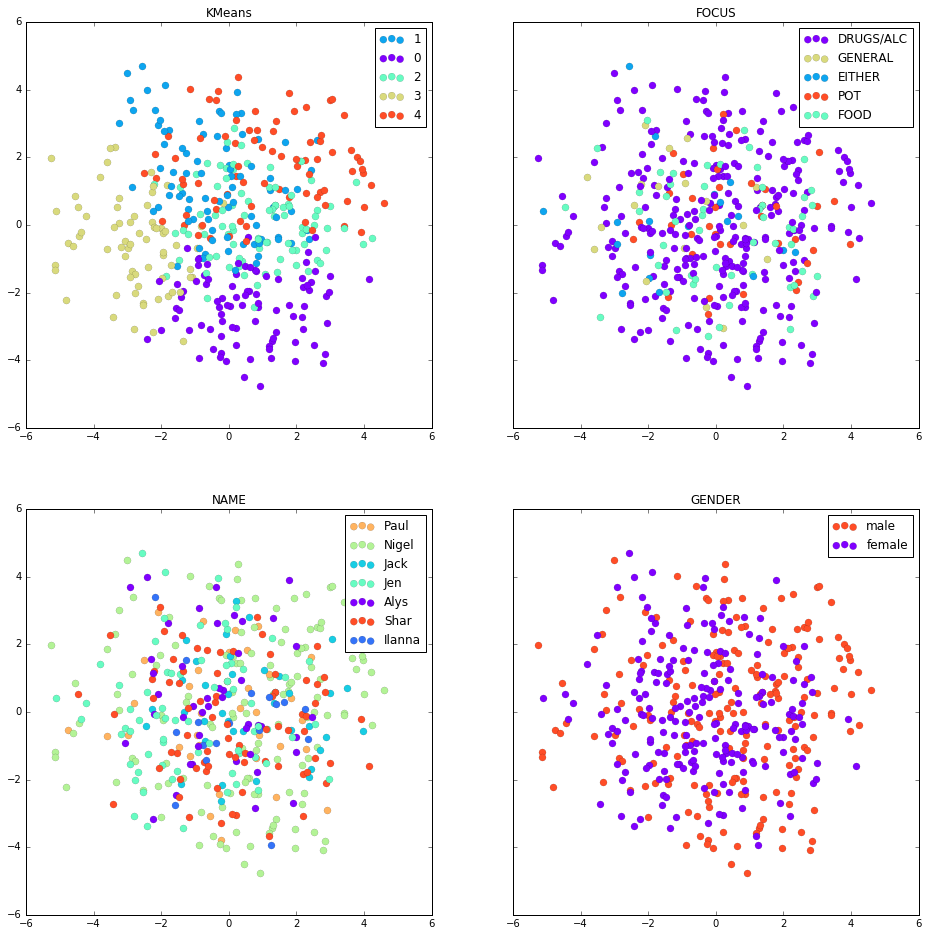

In [16]:
d_idx,feats = data2feats(df,word2vec,col=['TOPICS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=5,max_iter=500)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Word vectors are not well trained due to small size corpus. Perhaps try pretrained vectors.

# TOKENS + CATS/WELLGOS

Feats Shape:  (414, 5245)
Included:  dict_keys(['WELLGOS', 'TOKENS', 'CATS'])


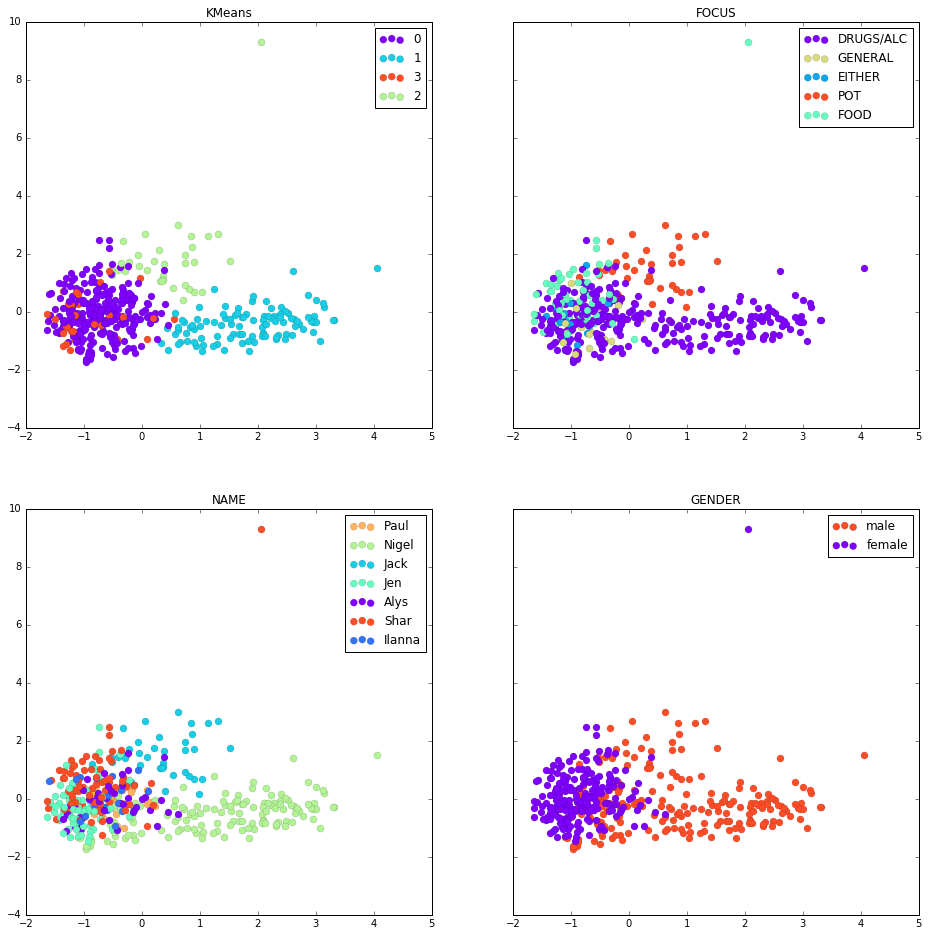

In [149]:
d_idx,feats = data2feats(df,col=['CATS','WELLGOS','TOKENS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=4,max_iter=300)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Similar to only tokens

# Non-Vec TOPICS

Feats Shape:  (414, 755)
Included:  dict_keys(['GENDER', 'nVecTOPICS'])


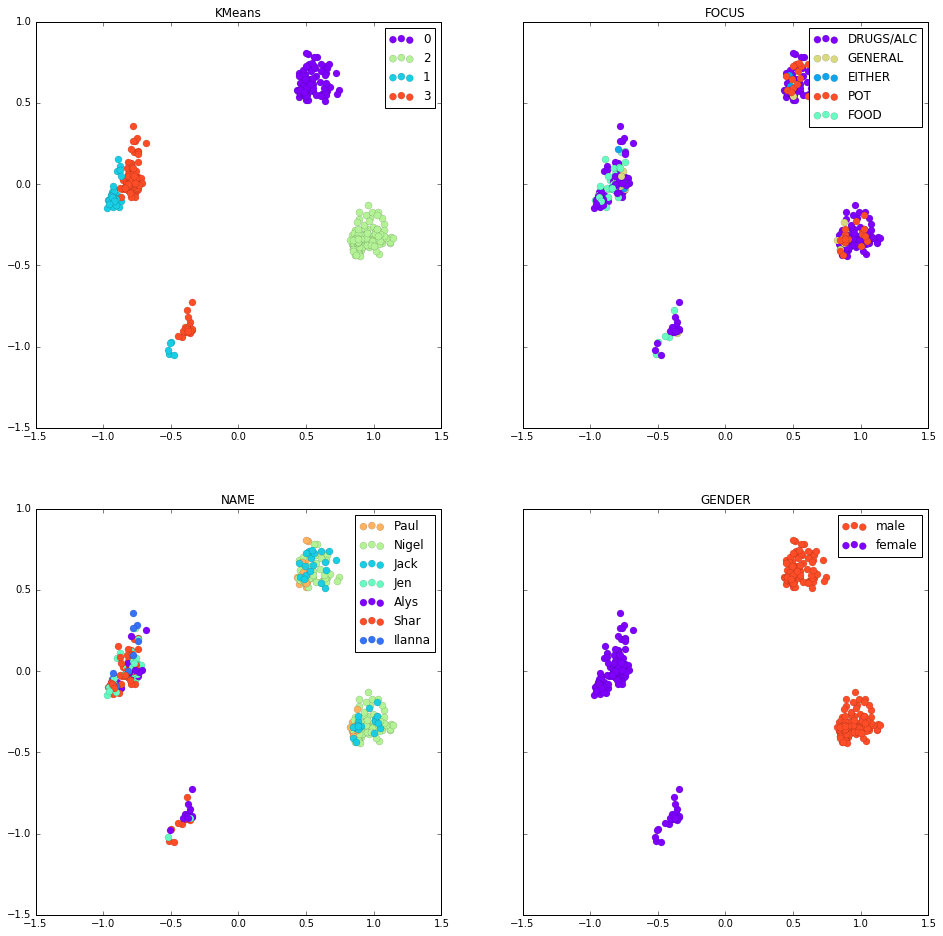

In [137]:
d_idx,feats = data2feats(df,col=['nVecTOPICS','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=4,max_iter=300)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Interesting fact that within each gender, there's two major group with similarity indside but clear difference between each other. Reason unclear yet, deeper comparasion suggested.

Perhaps difference is caused by 'wa' and 'n't' during normalization and preprocessing.

In [142]:
l0,l1,l2,l3 = getlabel(df,kmeans.labels_,clusters=[0,1,2,3])
count(df,'nVecTOPICS',l0,0,topN=25)
count(df,'nVecTOPICS',l2,2,topN=20)
count(df,'nVecTOPICS',l1,1,topN=20)
count(df,'nVecTOPICS',l3,3,topN=20)

Cluster 0: 90 examples
Counter({'male': 90})
Counter({'DRUGS/ALC': 66, 'POT': 19, 'EITHER': 3, 'GENERAL': 2})
Counter({'Nigel': 51, 'Paul': 20, 'Jack': 19})

Cluster 1: 40 examples
Counter({'female': 40})
Counter({'DRUGS/ALC': 26, 'FOOD': 14})
Counter({'Shar': 19, 'Jen': 12, 'Alys': 5, 'Ilanna': 4})

Cluster 2: 117 examples
Counter({'male': 117})
Counter({'DRUGS/ALC': 92, 'POT': 19, 'GENERAL': 6})
Counter({'Nigel': 83, 'Jack': 19, 'Paul': 15})

Cluster 3: 167 examples
Counter({'female': 167})
Counter({'DRUGS/ALC': 102, 'FOOD': 39, 'EITHER': 16, 'GENERAL': 10})
Counter({'Shar': 58, 'Jen': 56, 'Alys': 40, 'Ilanna': 13})

Total unique nVecTOPICS in Cluster 0: 265

Most Common: 
('life', 15)
("n't", 14)
("'s", 12)
('–', 11)
("'d", 10)
('way', 10)
('trigger', 8)
('drug', 7)
('addiction', 6)
('thing', 5)
('one', 5)
('could', 5)
('make', 5)
("'ve", 4)
('get', 4)
('time', 4)
('done', 4)
('control', 4)
('like', 4)
('pot', 4)
('better', 3)
('light', 3)
('i’m', 3)
('ha', 3)
('still', 3)


Total u

In [145]:
df.ix[l0] #Cluster 0

,RAW,CATS,WELLGOS,FOCUS,N,GENDER,TOKENS,TOPICS,nVecTOPICS
0,"Throughout my drinking career, instant gratifi...","PROGRESS / start small,INNER MASTERY / take a ...","Baby Step Embracer,Finish Line Forgetter,The M...",DRUGS/ALC,Paul,male,"took,instant,slowing,better,trades,none,learne...","master,step,wanted,baby,time","master,step,wanted,baby,time"
1,I tried to control every aspect of my life. Wh...,"CONTROL,SERENITY,FREEDOM / past & let go,TRUST...","Controller Coaster,Should Shover,Serenity Simu...",DRUGS/ALC,Paul,male,"Being,aspect,willpower,serenity,manager,go,lif...","go,control,thing,life,way","go,control,thing,life,way"
2,Thinking about drinking – the taste and feel –...,"CRAVINGS / will power & tools,INNER POWER / Se...","Pattern Interrupter,New Pattern Painter,Craver...",DRUGS/ALC,Paul,male,"lemon,cup,feel,harsh,starving,something,water,...","like,–,salivate,man,tipping","like,–,salivate,man,tipping"
3,I always thought today/this weekend/this week ...,"DELUSION,CONFESSION / denial,TRUTH / self honesty","Delusion Detector,Sabotage SOS’r,Insanity SOS’...",DRUGS/ALC,Paul,male,"week,purchase,whatever,admit,fooling,delusion,...","would,stop,time,better,drinking","would,stop,time,better,drinking"
5,Resigned to the fact that being poor or homele...,"CONFIDENCE / hope & future,FREEDOM / past & l...","Excuse Exterminator,Rationalization Rinser,Gra...",DRUGS/ALC,Paul,male,"don’t,homeless,continue,lot,life,drink,hands,m...","poor,homeless,life,better,fate","poor,homeless,life,better,fate"
6,"Alcohol was great for two things, suppressing ...","WORTHINESS / connections & sharing,VULNERABILI...","Emotions Engineer,Feelings Fantasizer,Compassi...",DRUGS/ALC,Paul,male,"words,others,“honest,back,feel,get,didn’t,anyo...","feeling,suppressing,else’s,didn’t,i’m","feeling,suppressing,else’s,didn’t,i’m"
7,I’ve started more things than I can count and ...,"COMMITMENTS,MOTIVATION,RESPONSIBILITY,INNER PO...","Finish Line Forgetter,The Procrastina-shunner,...",DRUGS/ALC,Paul,male,"hear,finish,instant,consider,have,past,pursue,...","thing,say,finish,start,disheartening","thing,say,finish,start,disheartening"
9,Diving headlong into whatever had caught my in...,"COMMITMENTS,PROGRESS / start small,INNER POWER...","Symbolic Stepper,New Pattern Painter / grit & ...",DRUGS/ALC,Paul,male,"anything,caught,interest,headlong,learned,what...","start,done,basic,knew,intelligent","start,done,basic,knew,intelligent"
12,"Embrace the suck. Life sucks, get a helmet. Th...","RESILIENCE / reaction & behavior,AGONY,MINDSET...","Misery Minister,Ill Feelings Illuminator,Depre...",DRUGS/ALC,Paul,male,"Sure,helmet,manageable,months,permanent,only,l...","misery,way,life,suck,day","misery,way,life,suck,day"
13,I was obsessed with everything. I obsessed ove...,"INNER POWER / Self control & willpower,FREEDOM...","Insanity SOS’r,Self awareness / habits & behav...",DRUGS/ALC,Paul,male,"lasted,obsessed,Today,passions,wrongs,while,mo...","obsession,obsessed,eye,everything,today","obsession,obsessed,eye,everything,today"


In [146]:
df.ix[l2] #Cluster2

,RAW,CATS,WELLGOS,FOCUS,N,GENDER,TOKENS,TOPICS,nVecTOPICS
4,The people around me only saw what I wanted th...,"CONFIDENCE / acceptance & worth,DELUSION,VULNE...","Self Esteem Elixir,Confidence Caffeinator,Inne...",DRUGS/ALC,Paul,male,"others,hide,lubricated,thought,mask,closest,wh...","friend,wa,see,reason,occasion","friend,wa,see,reason,occasion"
8,How great it was to have a friend that I could...,"EGO,PRIDE ,INFLUENCES,COMMUNITY / healthy rela...","Foul Weather Friender,Arrogance Arrestor,Pride...",DRUGS/ALC,Paul,male,"feel,complain,Looking,help,have,everyone,harm,...","friend,wa,person,like,superior","friend,wa,person,like,superior"
10,"When I was drinking, I didn’t just distance my...","INFLUENCES,LONELINESS,GROWTH / motivation & bo...","Isolation SOS’r,Bad Influence Butcher,WAIT AND...",DRUGS/ALC,Paul,male,"continue,offering,distance,who,what,anyone,dis...","didn’t,wa,people,distance,harm","didn’t,wa,people,distance,harm"
11,I did it; it was all me. Nobody or no thing ha...,"GRATITUDE / for others,CHANGE / self love & tr...","Miracle Embracer,Ego Eclipser,Pride Polisher,A...",DRUGS/ALC,Paul,male,"anything,based,have,miracle,newfound,been,happ...","miracle,wa,thing,sober,it’s","miracle,wa,thing,sober,it’s"
14,I only dealt in absolutes when I drank. I was ...,"GROWTH / behavior & habits,EGO,PROGRESS / reac...","Pride Puffer,Ego Eclipser,Arrogance Arrestor,N...",DRUGS/ALC,Paul,male,"changes,continue,others,positive,second,change...","wa,second,nature,change,keep","wa,second,nature,change,keep"
16,My world was black and white while I was drink...,"GROWTH / learning & mistakes,RESILIENCE / reac...","Perspective Detective,Daily Daisy Spotter,Blun...",DRUGS/ALC,Paul,male,"have,gift,ways,black,look,something,learned,li...","something,problem,wa,fail,people","something,problem,wa,fail,people"
17,How impulsive I was. I never had time to make ...,"PROGRESS / future & hope,MINDSET,GROWTH / supp...","Values VIP’r,Soul Proprietor,Sobriety 101'r,WA...",DRUGS/ALC,Paul,male,"bother,worst,ways,did,what’s,busy,easier,other...","plan,wa,make,take,best","plan,wa,make,take,best"
19,"When I was drinking, I could only be best desc...","INNER MASTERY / beliefs & awareness,URGES / to...","Placid Reflux,Urge Auditor,Compulsion KO’r,Sel...",DRUGS/ALC,Paul,male,"help,separate,urges,downright,command,somethin...","urge,bad,wa,deep,succumbing","urge,bad,wa,deep,succumbing"
22,"When I was drinking, I thought I was pretty go...","HEALING,GROWTH / true self,INNER / SELF / harm...","Whole Soul Healer,Serenity Soulmater,Inner Sou...",DRUGS/ALC,Paul,male,"anything,don’t,aspect,come,meditation,been,oth...","soul,good,much,wa,know","soul,good,much,wa,know"
24,Abstinence... it was a hard thing for me to ap...,"SOBRIETY / costs & benefits,ABSTINENCE,INNER P...","Abstainer Amazer,Demon Dethroner ,COMMITMENT k...",DRUGS/ALC,Nigel,male,"took,addiction,detox,compare,have,stood,fell,y...","abstinence,wa,thing,lost,fell","abstinence,wa,thing,lost,fell"


# DRUGS/ALC vs FOOD

In [4]:
df_drug = df[df['FOCUS'].str.contains("DRUGS/ALC")]
df_food = df[df['FOCUS'].str.contains("FOOD")]
df_df = df.loc[(df['FOCUS'] == 'DRUGS/ALC') | (df['FOCUS'] == 'FOOD')]
df_df.index = range(len(df_df))

# DRUGS/ALC vs FOOD - TOKENS

Feats Shape:  (339, 3899)
Included:  dict_keys(['TOKENS', 'GENDER'])


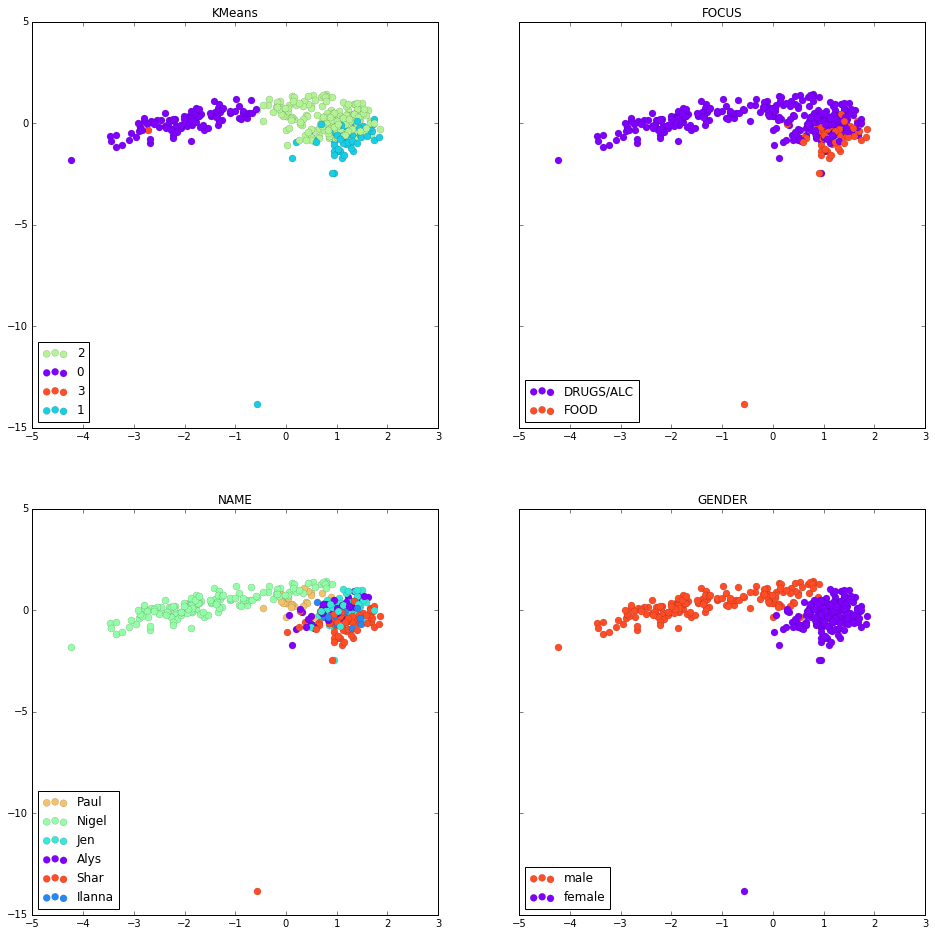

In [12]:
d_idx,feats = data2feats(df_df,word2vec,col=['TOKENS','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=4)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df_df)

Nigel is typical DRUGS/ALC person, Nigels talks in similar way, high frequently used words such as: drug, life, friend, could, would etc., reflecting that male focuses more in their past and themselves, regreting about things that they shouldn't do, expressing negativity in general.

In contras, female focus more on present, recovery, feeling, more positive comparing to male. 'god' is relatively more frequently in female samples. In addition, female samples share similarity in terms of language in FOOD and DRUGS/ALC categories.

In [13]:
l0,l1,l2 = getlabel(df_df,kmeans.labels_,clusters=[0,1,2])
count(df_df,'TOKENS',l0,0,topN=20,pos=True)
count(df_df,'TOKENS',l1,1,topN=20,pos=True)
count(df_df,'TOKENS',l2,2,topN=20,pos=True)

Cluster 0: 104 examples
Counter({'male': 104})
Counter({'DRUGS/ALC': 104})
Counter({'Nigel': 104})

Cluster 1: 60 examples
Counter({'female': 60})
Counter({'FOOD': 35, 'DRUGS/ALC': 25})
Counter({'Shar': 43, 'Jen': 8, 'Ilanna': 6, 'Alys': 3})

Cluster 2: 174 examples
Counter({'female': 121, 'male': 53})
Counter({'DRUGS/ALC': 156, 'FOOD': 18})
Counter({'Jen': 43, 'Alys': 39, 'Shar': 29, 'Nigel': 29, 'Paul': 24, 'Ilanna': 10})

Total unique TOKENS in Cluster 0: 2280

Most Common Verbs: 
('wa', 431)
("'m", 61)
('got', 56)
('get', 53)

Most Common non-Verbs: 
("'d", 176)
('drug', 163)
("n't", 157)
('life', 131)
('–', 115)
('could', 99)
('friend', 96)
('addiction', 82)
("'s", 81)
('would', 63)
('thing', 61)
('detox', 60)
('though', 55)
('time', 52)
('never', 50)
('people', 50)


Total unique TOKENS in Cluster 1: 1429

Most Common Verbs: 
('get', 40)
('feeling', 32)
('make', 30)

Most Common non-Verbs: 
('recovery', 75)
('food', 50)
('life', 46)
('one', 41)
('help', 39)
('work', 39)
('like', 

# DRUGS/ALC - TOPICS

Feats Shape:  (339, 669)
Included:  dict_keys(['GENDER', 'nVecTOPICS'])


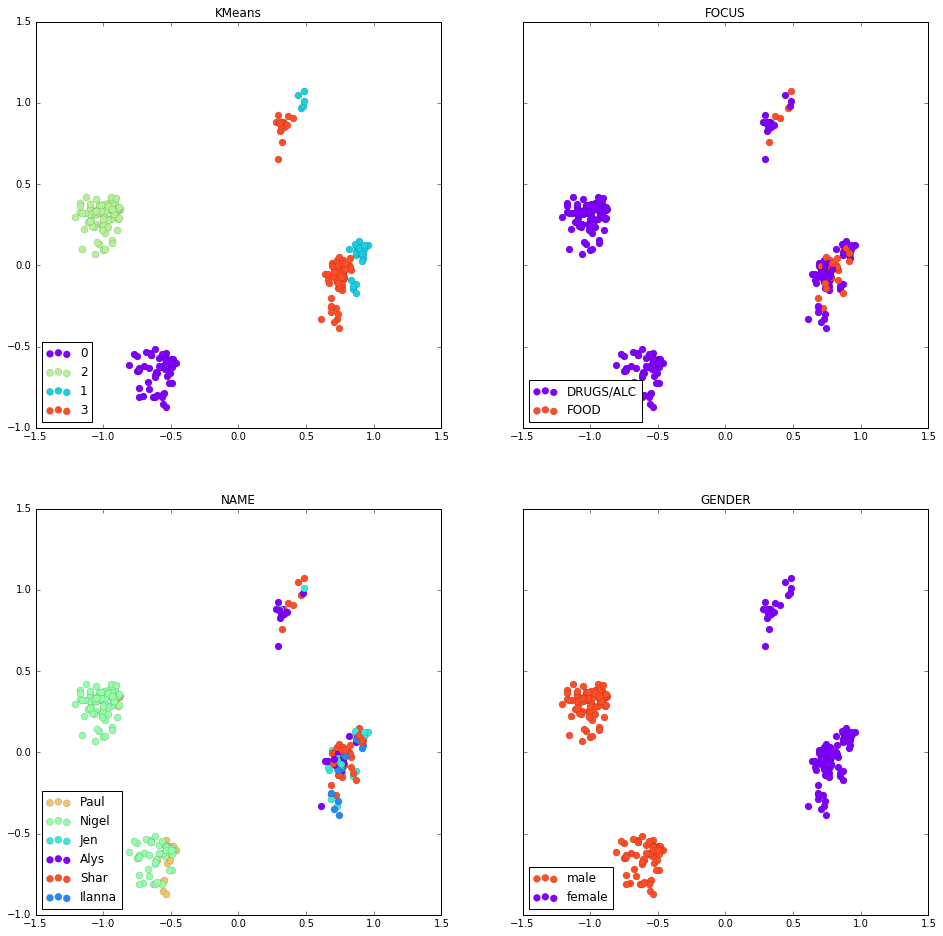

In [181]:
d_idx,feats = data2feats(df_df,col=['nVecTOPICS','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=4)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df_df)

In [182]:
l0,l1,l2,l3 = getlabel(df_df,kmeans.labels_,clusters=[0,1,2,3])
count(df_df,'nVecTOPICS',l0,0,topN=25)
count(df_df,'nVecTOPICS',l2,2,topN=20)
count(df_df,'nVecTOPICS',l1,1,topN=20)
count(df_df,'nVecTOPICS',l3,3,topN=20)

Cluster 0: 66 examples
Counter({'male': 66})
Counter({'DRUGS/ALC': 66})
Counter({'Nigel': 51, 'Paul': 15})

Cluster 1: 40 examples
Counter({'female': 40})
Counter({'DRUGS/ALC': 26, 'FOOD': 14})
Counter({'Shar': 19, 'Jen': 12, 'Alys': 5, 'Ilanna': 4})

Cluster 2: 92 examples
Counter({'male': 92})
Counter({'DRUGS/ALC': 92})
Counter({'Nigel': 83, 'Paul': 9})

Cluster 3: 141 examples
Counter({'female': 141})
Counter({'DRUGS/ALC': 102, 'FOOD': 39})
Counter({'Shar': 53, 'Jen': 39, 'Alys': 37, 'Ilanna': 12})

Total unique nVecTOPICS in Cluster 0: 218

Most Common: 
('life', 12)
('–', 11)
("'d", 10)
('drug', 7)
('way', 7)
("'s", 7)
("n't", 7)
('thing', 4)
("'ve", 4)
('time', 4)
('light', 3)
('could', 3)
('done', 3)
('everything', 3)
('control', 3)
('make', 3)
('friend', 3)
('maybe', 3)
('feeling', 3)
('like', 3)
('blame', 3)
('step', 2)
('depression', 2)
('there’s', 2)
('bridge', 2)


Total unique nVecTOPICS in Cluster 2: 226

Most Common: 
('wa', 92)
("'d", 20)
("n't", 17)
('drug', 16)
('–', 

# WELLGOS Comparasion DRUGS/ALC vs FOOD

In [173]:
l0,l1,l2 = getlabel(df_df,kmeans.labels_,clusters=[0,1,2])
count(df_df,'WELLGOS',l0,0,topN=10)
count(df_df,'WELLGOS',l1,1,topN=10)
count(df_df,'WELLGOS',l2,2,topN=10)

Cluster 0: 128 examples
Counter({'female': 128})
Counter({'DRUGS/ALC': 128})
Counter({'Jen': 51, 'Alys': 42, 'Shar': 22, 'Ilanna': 13})

Cluster 1: 53 examples
Counter({'female': 53})
Counter({'FOOD': 53})
Counter({'Shar': 50, 'Ilanna': 3})

Cluster 2: 158 examples
Counter({'male': 158})
Counter({'DRUGS/ALC': 158})
Counter({'Nigel': 134, 'Paul': 24})

Total unique WELLGOS in Cluster 0: 268

Most Common: 
('RELATIONSHIPS / Build connections & community', 9)
('Reactions Auditor', 8)
('NEW LIFE / POSSIBILITIES', 8)
('ADMIT / accountability', 8)
('Killer Kickstarter', 7)
('Inner Power Allower', 7)
("Self Control 101'r", 7)
('Symbolic Stepper', 7)
('Bitter Truth Taster', 7)
('Progress Pollinator', 6)


Total unique WELLGOS in Cluster 1: 151

Most Common: 
('Ill Feelings Illuminator', 5)
('SELF HARM / Tools', 5)
('VULNERABILITY / reach out for help', 5)
('SELF HARM ALARMER / avoid triggers', 5)
('Deep Down Diver', 4)
('New Pattern Painter / confidence & awareness', 4)
('Self awareness / habi

# CATS Comparasion DRUGS/ALC vs FOOD

In [175]:
l0,l1,l2 = getlabel(df_df,kmeans.labels_,clusters=[0,1,2])
count(df_df,'CATS',l0,0,topN=10)
count(df_df,'CATS',l1,1,topN=10)
count(df_df,'CATS',l2,2,topN=10)

Cluster 0: 128 examples
Counter({'female': 128})
Counter({'DRUGS/ALC': 128})
Counter({'Jen': 51, 'Alys': 42, 'Shar': 22, 'Ilanna': 13})

Cluster 1: 53 examples
Counter({'female': 53})
Counter({'FOOD': 53})
Counter({'Shar': 50, 'Ilanna': 3})

Cluster 2: 158 examples
Counter({'male': 158})
Counter({'DRUGS/ALC': 158})
Counter({'Nigel': 134, 'Paul': 24})

Total unique CATS in Cluster 0: 163

Most Common: 
('COMMUNITY / listen to guidance', 8)
('ACCOUNTABILITY / Own up', 8)
('CONFIDENCE /  hope & future', 8)
('FREEDOM / future & growth', 7)
('INFLUENCES', 7)
('GROWTH / motivation & boosts', 7)
('FREEDOM / past & let go', 6)
('INNER POWER / Vulnerability', 6)
('VULNERABILITY / learning and mistakes', 6)
('WORTHINESS / new life & future', 6)


Total unique CATS in Cluster 1: 97

Most Common: 
('CONFESSION / admit', 5)
('INNER MASTERY / challenge & resilience', 5)
('VULNERABILITY / Show true self', 5)
('TRUTH / Admit addiction', 4)
('GOD / reach out', 4)
('DEMONS', 4)
('SOBRIETY / celebrate & 